# Poisson regression (GAM) COVID-19 Prediction

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_colwidth = 500

# Data viz
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

plotly.offline.init_notebook_mode()
sns.set(style="darkgrid", rc={"figure.figsize": (11.7, 8.27)})

# Modeling
from pygam import PoissonGAM, s, l, f

# Other
from datetime import date, timedelta
import os
import random
import sys

# Custom module
module_path = os.path.abspath(os.path.join("../src"))
if module_path not in sys.path:
    sys.path.append(module_path)

from plotting import plot_predictions
from stem_poisson_gam import StemPoissonRegressor

# Reload imported code
%reload_ext autoreload
%autoreload 2

# Print all output
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Set seeds for reproducibility
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## About

The goal is to provide the most accurate forecasts for COVID-19 in Canada for new cases, deaths and recovered cases.  We'll be using an approach similar to that in the paper [Spatiotemporal Dynamics, Nowcasting and Forecasting of COVID-19 in the United States](https://arxiv.org/abs/2004.14103) which uses a generalized additive model with Poisson distribution using temporal variables (number of infected, susceptible cases at time $t-1$), spatial coordinates, time varying covariates (control measures), and constant covariates (demographic, economic, etc). For now we only use temporal variables $I_{it}$ and $Z_{it}$.

## Load data and EDA

**Given variables**
- $Y_{it}$: Current number of new case at time t for area i. Column "cases" in cases_timeseries_prov.csv
- $I_{it}$: Cumulative number of active infectious cases. Column "active_cases" in active_timeseries_prov.csv
- $C_{it}$: Cumulative confirmed cases up to time t. Column "cumulative_cases" in active_timeseries_prov.csv
- $R_{it}$: Cumulative number of infections. Column "cumulative_recovered" in active_timeseries_prov.csv

**Transformed variables**
- $N_{i}$: Population of region i. Column "population"
- $\Delta D_{it}$: New deaths/recovered cases at time t. Column "removed"
- $S_{it}$: Number of susceptible subjects at time t defined by $S_{it} = N_i - C_{it}$. Column "susceptible"
- $Z_{it}$: Log ratio of susceptible subjects $Z_{it} = log(S_{it} / N_i)$. Column "percent_susceptible" without log transform.

In [2]:
# Read in data
data_path = '../data/timeseries_prov'
cases_provinces = pd.read_csv(data_path + '/cases_timeseries_prov.csv')
active_cases_provinces = pd.read_csv(data_path +  '/active_timeseries_prov.csv')
mortality_provinces = pd.read_csv(data_path + '/mortality_timeseries_prov.csv')
recovered_provinces = pd.read_csv(data_path + '/recovered_timeseries_prov.csv')

# Province population data
prov_map = {
    'British Columbia': 'BC',
    'Newfoundland and Labrador': 'NL', 
    'Northwest Territories': 'NWT',
    'Prince Edward Island': 'PEI'
}

province_populations = (
    pd.read_csv('../data/canada_prov_population.csv')
    .rename(columns = {'GEO': 'province', 'VALUE': 'population'})
    .replace({'province': prov_map})
    .loc[:, ['province', 'population']]
)


# Preprocessing dataframes to be merged
recovered_provinces = recovered_provinces.rename(columns = {'date_recovered': 'date'}).loc[:, ['province', 'date', 'recovered']]
mortality_provinces = mortality_provinces.rename(columns = {'date_death_report': 'date'}).loc[:, ['province', 'date', 'deaths']]

# Preprocessing
format = "%d-%m-%Y"
active_cases_provinces = (
    active_cases_provinces
    .rename(columns = {"date_active": "date"})
    
    # Merge deaths and recovered data
    .merge(mortality_provinces, how='left', on=['province', 'date'])
    .merge(recovered_provinces, how='left', on=['province', 'date'])
    .fillna(0)
    
    # Format date and add new cases data
    .assign(date = lambda x: pd.to_datetime(x["date"], format=format).dt.date,
            cases = cases_provinces['cases'])
    .query('province != "Repatriated"')
    
    # Add population data per province
    .merge(province_populations, how='left', on='province')
    
    # Add transformed variables
    .assign(removed = lambda x: x['recovered'] + x['deaths'],
            susceptible = lambda x: x['population'] - x['cumulative_cases'],
            percent_susceptible = lambda x: x['susceptible'] / x['population'])
)

# Get first and last day of reports
start_date = active_cases_provinces["date"].min()
end_date = active_cases_provinces["date"].max()

# Get list of provinces
provinces = active_cases_provinces["province"].unique()
provinces = ['Ontario', 'Quebec', 'BC', 'Alberta']

# Save dataframe
active_cases_provinces.to_csv('../data/active_cases_provinces.csv')

# Show dataframe
active_cases_provinces.head(10)

province        date  cumulative_cases  cumulative_recovered  \
0  Alberta  2020-01-25                 0                     0   
1  Alberta  2020-01-26                 0                     0   
2  Alberta  2020-01-27                 0                     0   
3  Alberta  2020-01-28                 0                     0   
4  Alberta  2020-01-29                 0                     0   
5  Alberta  2020-01-30                 0                     0   
6  Alberta  2020-01-31                 0                     0   
7  Alberta  2020-02-01                 0                     0   
8  Alberta  2020-02-02                 0                     0   
9  Alberta  2020-02-03                 0                     0   

   cumulative_deaths  active_cases  active_cases_change  deaths  recovered  \
0                  0             0                    0     0.0        0.0   
1                  0             0                    0     0.0        0.0   
2                  0             0                    0     0.0        0.0   
3                  0             0                    0     0.0        0.0   
4                  0             0                    0     0.0        0.0   
5                  0             0                    0     0.0        0.0   
6                  0             0                    0     0.0        0.0   
7                  0             0                    0     0.0        0.0   
8                  0             0                    0     0.0        0.0   
9                  0             0                    0     0.0        0.0   

   cases  population  removed  susceptible  percent_susceptible  
0      0     4421876      0.0      4421876                  1.0  
1      0     4421876      0.0      4421876                  1.0  
2      0     4421876      0.0      4421876                  1.0  
3      0     4421876      0.0      4421876                  1.0  
4      0     4421876      0.0      4421876                  1.0  
5      0     4421876      0.0      4421876                  1.0  
6      0     4421876      0.0      4421876                  1.0  
7      0     4421876      0.0      4421876                  1.0  
8      0     4421876      0.0      4421876                  1.0  
9      0     4421876      0.0      4421876                  1.0

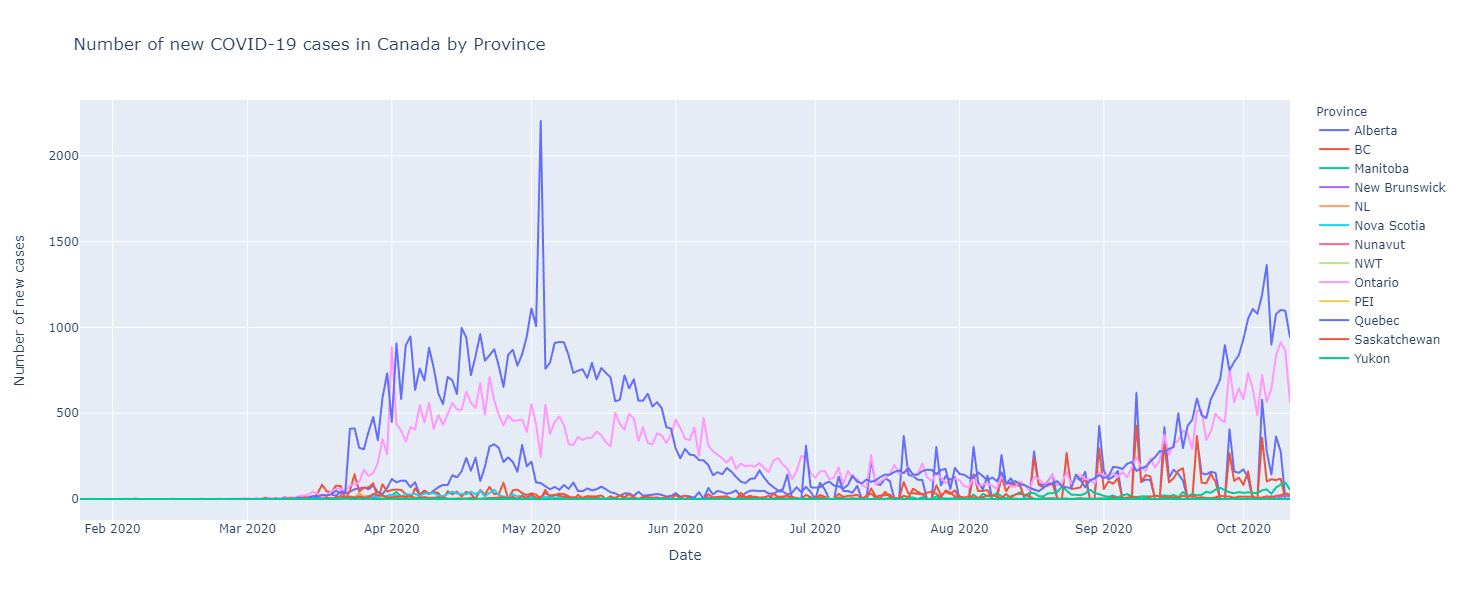

In [3]:
# Plot Y_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cases",
    color="province",
    title="Number of new COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cases="Number of new cases",
        province="Province",
    ),
    height=600,
)
fig.show()

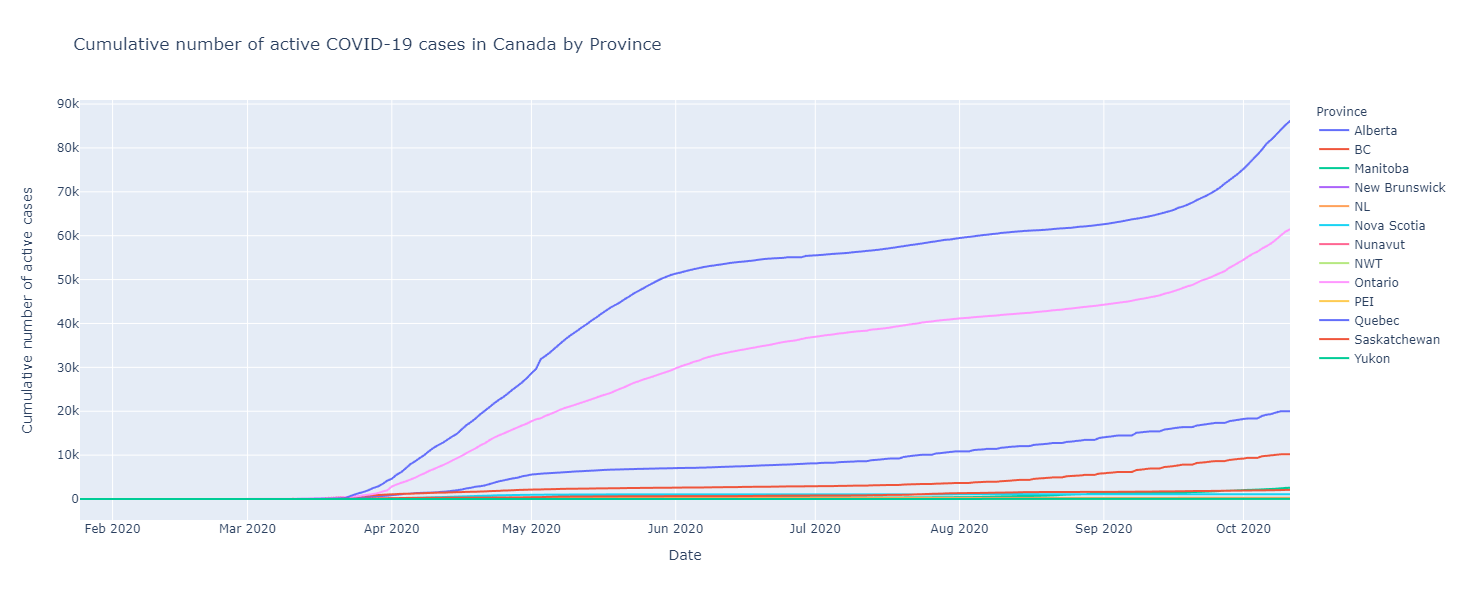

In [4]:
# Plot C_it cumulative active cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="cumulative_cases",
    color="province",
    title="Cumulative number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        cumulative_cases="Cumulative number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

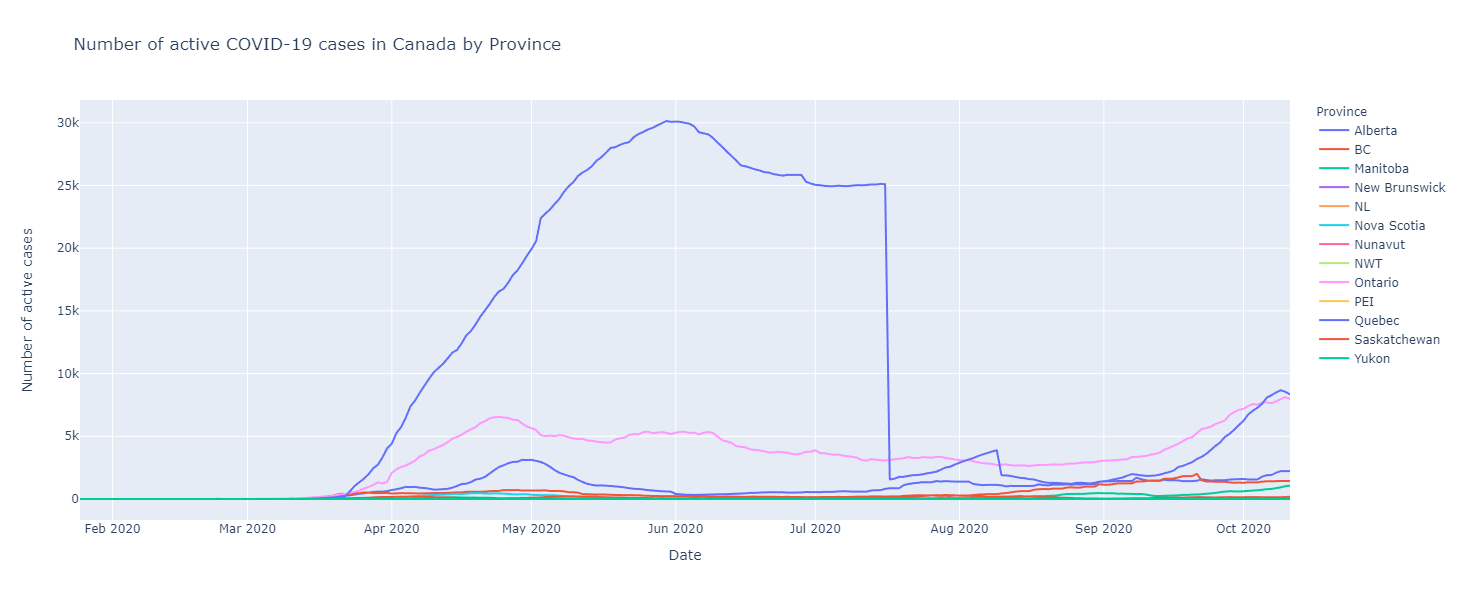

In [5]:
# Plot I_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="active_cases",
    color="province",
    title="Number of active COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        active_cases="Number of active cases",
        province="Province",
    ),
    height=600,
)
fig.show()

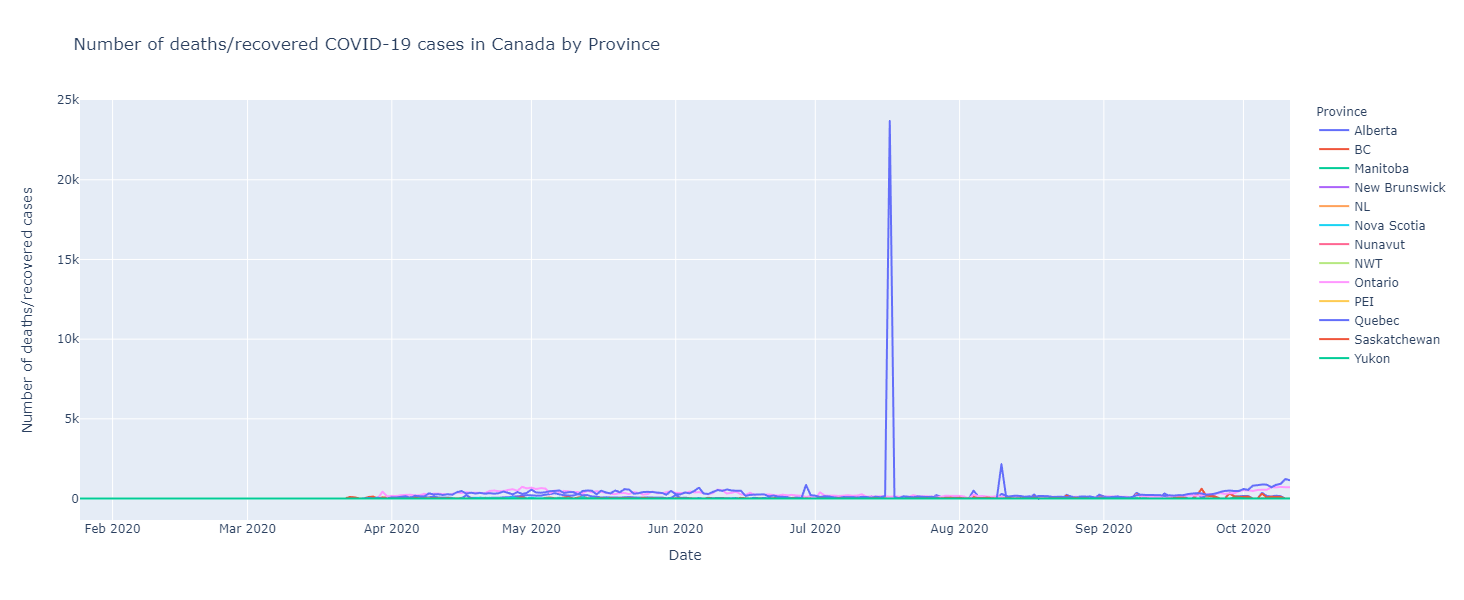

In [6]:
# Plot delta D_it new cases for each province
fig = px.line(
    active_cases_provinces,
    x="date",
    y="removed",
    color="province",
    title="Number of deaths/recovered COVID-19 cases in Canada by Province",
    labels=dict(
        date="Date",
        removed="Number of deaths/recovered cases",
        province="Province",
    ),
    height=600,
)
fig.show()

In [7]:
# Remove data before March 1

# remove_date = date(day=1, month=3, year=2020)
# active_cases_provinces = active_cases_provinces.query("date >= @remove_date")

### Comments

- Seems to be a seasonal component in the $Y_{it}$ plot of about 1 week appeearing roughly on Mondays and Tuesdays. This could be that the most testing happens over the weekends and thus the cases are displayed the start of the next week.
- Large dip in active cases in Quebec on July 17 - https://globalnews.ca/news/7190163/canada-coronavirus-cases-july-17/
- Spike in new cases in Quebec on May 3- https://www.cbc.ca/news/canada/montreal/covid-19-quebec-may-3-1.5553881
- Mortality data starts March 8, 2020 so we will just ignore all dates before March
- Warning: Innacurate measurements of new and active cases, recovered, deaths, etc such as this could add too much noise and lead to poor model performance. Might be a good idea to ignore that portion of Quebec and use the latest data instead.

## Poisson regression

For a given province $i$ we have

$$
Y_t \sim Poisson(\mu_t) \\
log(\mu_t) = \beta_{1t} + \beta_{2t}log(I_{t-1} + 1) + \alpha_tlog(S_{t-1}/N) 
$$

and

$$
\Delta D_t \sim Poisson({\mu_t}^D) \\
log({\mu_t}^D) = \beta_{1t}^D + \beta_{2t}^D log(I_{t-1} + 1)
$$

We will also be applying cross-validation on each fold to prevent overfitting.

In [8]:
# Filter Ontario
cases_ontario = active_cases_provinces.query('province == "Ontario"')

# Fit poisson model
X = cases_ontario[['date', 'active_cases', 'percent_susceptible']]
Y = cases_ontario[['cases', 'removed']]


stem_poisson = StemPoissonRegressor()
stem_poisson.fit(X, Y)

stem_poisson.poisson_gam_cases.summary()

PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                      2.0946
Link Function:                          LogLink Log Likelihood:                                 -7617.8847
Number of Samples:                          260 AIC:                                            15239.9585
                                                AICc:                                           15240.0576
                                                UBRE:                                              54.5223
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.7359
Feature Function                  Lam

<ipython-input-8-090136fb480d>:12: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




In [9]:
# Get h step predictions
C = cases_ontario['cumulative_cases'].iloc[-1]
N = cases_ontario['population'].iloc[-1]
h = 14 #2 weeks

forecasts = stem_poisson.forecast(C = C, N = N, h = h)

# Merge forecasts with actual data
forecasts = forecasts.merge(cases_ontario, how='left', on='date')

forecasts.tail(15)

date  cases_pred  removed_pred  active_cases_pred  is_forecast  \
259  2020-10-11  568.904925    705.502711                NaN        False   
260  2020-10-12  558.500555    686.323937        7850.176619         True   
261  2020-10-13  549.172909    669.340250        7730.009278         True   
262  2020-10-14  540.398453    653.512253        7616.895478         True   
263  2020-10-15  532.133410    638.736761        7510.292127         True   
264  2020-10-16  524.338342    624.921995        7409.708474         True   
265  2020-10-17  516.977630    611.986081        7314.700023         True   
266  2020-10-18  510.019027    599.855784        7224.863267         True   
267  2020-10-19  503.433275    588.465419        7139.831123         True   
268  2020-10-20  497.193769    577.755931        7059.268960         True   
269  2020-10-21  491.276266    567.674093        6982.871134         True   
270  2020-10-22  485.658636    558.171823        6910.357947         True   
271  2020-10-23  480.320635    549.205591        6841.472992         True   
272  2020-10-24  475.243713    540.735903        6775.980801         True   
273  2020-10-25  470.410842    532.726859        6713.664784         True   

    province  cumulative_cases  cumulative_recovered  cumulative_deaths  \
259  Ontario           61464.0               50437.0             3049.0   
260      NaN               NaN                   NaN                NaN   
261      NaN               NaN                   NaN                NaN   
262      NaN               NaN                   NaN                NaN   
263      NaN               NaN                   NaN                NaN   
264      NaN               NaN                   NaN                NaN   
265      NaN               NaN                   NaN                NaN   
266      NaN               NaN                   NaN                NaN   
267      NaN               NaN                   NaN                NaN   
268      NaN               NaN                   NaN                NaN   
269      NaN               NaN                   NaN                NaN   
270      NaN               NaN                   NaN                NaN   
271      NaN               NaN                   NaN                NaN   
272      NaN               NaN                   NaN                NaN   
273      NaN               NaN                   NaN                NaN   

     active_cases  active_cases_change  deaths  recovered  cases  population  \
259        7978.0               -143.0     2.0      705.0  564.0  14734014.0   
260           NaN                  NaN     NaN        NaN    NaN         NaN   
261           NaN                  NaN     NaN        NaN    NaN         NaN   
262           NaN                  NaN     NaN        NaN    NaN         NaN   
263           NaN                  NaN     NaN        NaN    NaN         NaN   
264           NaN                  NaN     NaN        NaN    NaN         NaN   
265           NaN                  NaN     NaN        NaN    NaN         NaN   
266           NaN                  NaN     NaN        NaN    NaN         NaN   
267           NaN                  NaN     NaN        NaN    NaN         NaN   
268           NaN                  NaN     NaN        NaN    NaN         NaN   
269           NaN                  NaN     NaN        NaN    NaN         NaN   
270           NaN                  NaN     NaN        NaN    NaN         NaN   
271           NaN                  NaN     NaN        NaN    NaN         NaN   
272           NaN                  NaN     NaN        NaN    NaN         NaN   
273           NaN                  NaN     NaN        NaN    NaN         NaN   

     removed  susceptible  percent_susceptible  
259    707.0   14672550.0             0.995828  
260      NaN          NaN                  NaN  
261      NaN          NaN                  NaN  
262      NaN          NaN                  NaN  
263      NaN          NaN                  NaN  
26

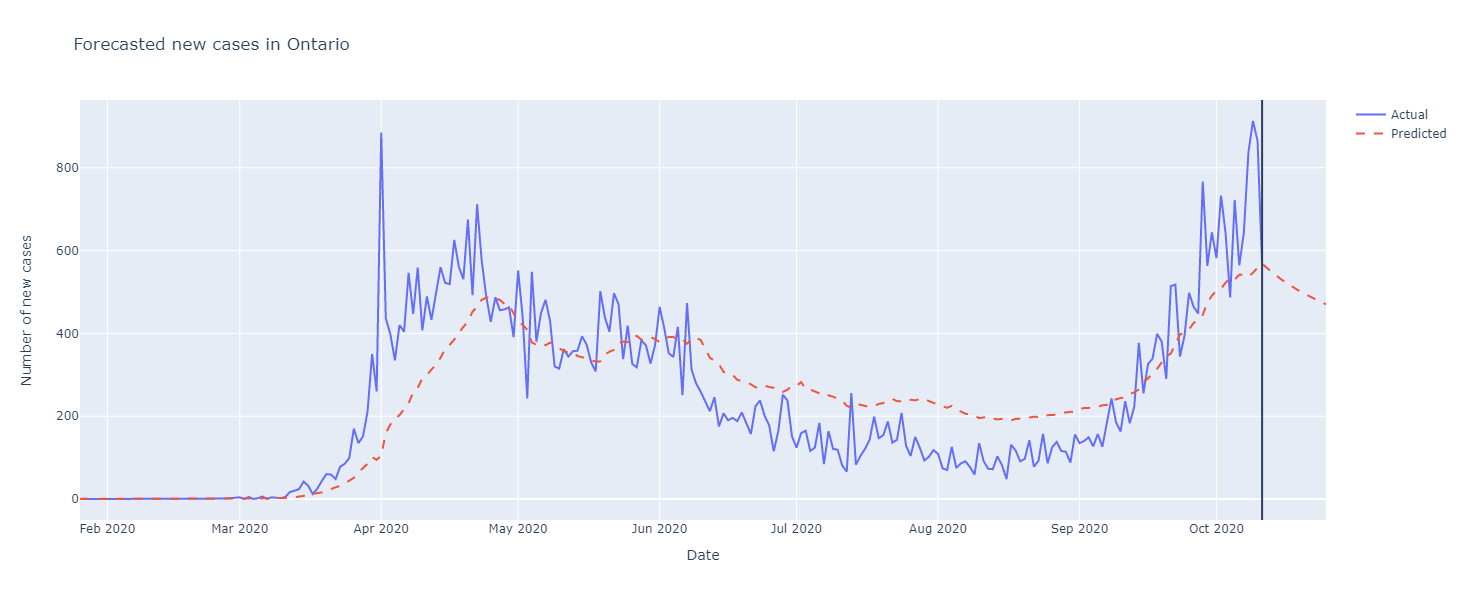

In [10]:
plot_predictions(forecasts,
                 y_actual = 'cases',
                 y_pred = 'cases_pred',
                 y_label = 'Number of new cases',
                 title = 'Forecasted new cases in Ontario')

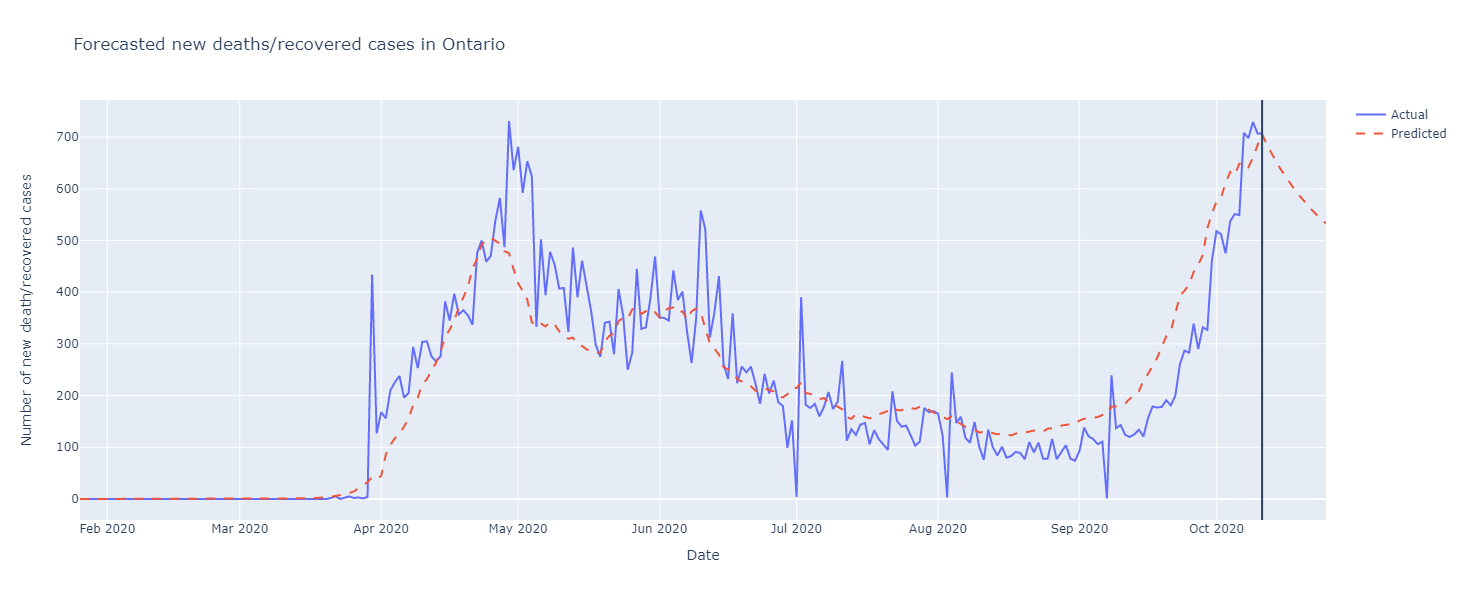

In [11]:
plot_predictions(forecasts,
                 y_actual = 'removed',
                 y_pred = 'removed_pred',
                 y_label = 'Number of new death/recovered cases',
                 title = 'Forecasted new deaths/recovered cases in Ontario')

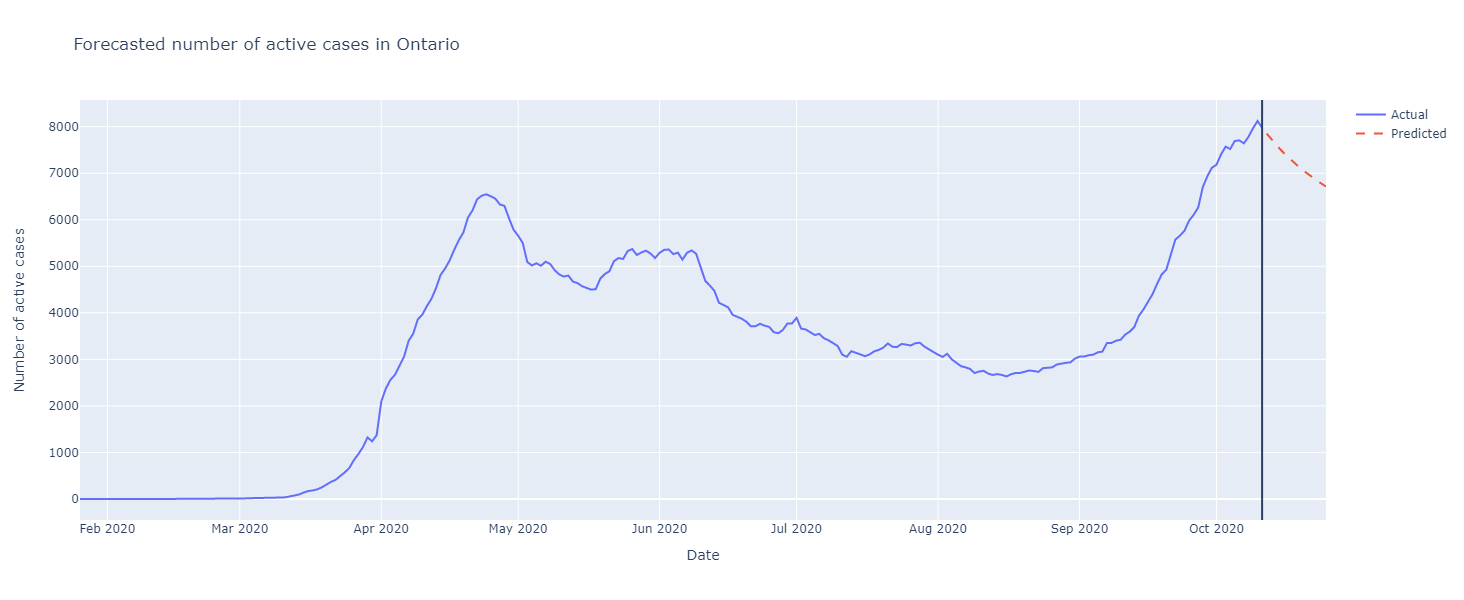

In [12]:
plot_predictions(forecasts,
                 y_actual = 'active_cases',
                 y_pred = 'active_cases_pred',
                 y_label = 'Number of active cases',
                 title = 'Forecasted number of active cases in Ontario')